Just importing stuff

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import PyQt5
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model

In [4]:
data = pd.read_csv("../complete_merged.csv",index_col=0)

Consecutive date checking function (Some districts had partial data)

In [5]:
#Testing datetime consecutiveness
import datetime as dt

def checkConsecutive(date_strs):
    dates = [dt.datetime.strptime(d, "%Y-%m-%d") for d in date_strs]

    date_ints = set([d.toordinal() for d in dates])
    if len(date_ints) == 1:
        return True
    elif max(date_ints) - min(date_ints) == len(date_ints) - 1:
        return True
    else:
        return False




# date_strs = ['02-29-2012', '02-28-2012', '03-01-2012']
date_strs = ['1999-12-31','2000-01-01']
checkConsecutive(date_strs)



True

Split Sequence(Standard function for splitting data for univariate lstm)

In [6]:
def split_sequence(date_sequence,temp_sequence, n_steps):
    X, y = list(), list()
    for i in range(len(temp_sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
 # check if we are beyond the sequence
        if end_ix > len(temp_sequence)-1:
            break
 # gather input and output parts of the pattern
        seq_x, seq_y = temp_sequence[i:end_ix], temp_sequence[end_ix]
        date_seq = date_sequence[i:end_ix]
        # print(checkConsecutive(seq_x))
        if(checkConsecutive(date_seq)):
            X.append(seq_x)
            y.append(seq_y)
        
    return np.array(X), np.array(y)





In [7]:
#Basic Check
X,y = split_sequence(['2021-01-09','2021-01-11','2021-01-12','2021-01-13','2021-01-14'],[10, 20, 30, 40, 50],3)
for i in range(len(X)):
    print(X[i], y[i])

[20 30 40] 50


In [8]:
def convertUnivariateData(date_data,temp_data,n_steps,n_features):
    X, y = split_sequence(date_data,temp_data, n_steps)
# summarize the data
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return (X,y)

Defining the model

In [9]:
#different optimizers and loss functions need to be tested yet
n_steps = 10
n_features = 1
# epochs =20
epochs =200
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')



Function to evaluate model(Mean Square Error)

In [10]:
def evalLSTM(model,X,y,n_steps,n_features):
    y_predict = list()
    for i in range(X.shape[0]):
        x_input = X[i]
        x_input = x_input.reshape((1, n_steps, n_features))
        predicted_value = model.predict(x_input, verbose=0)[0][0]
        print(len(y_predict),"of",X.shape[0])
        y_predict.append(predicted_value)
    
    mse = tf.keras.losses.MeanSquaredError()
    return {'mse':mse(y_predict,y).numpy(),'y_predict':y_predict}


Basic check for Adilabad

In [11]:
data_Adilabad = data[data['district'] == "Adilabad"].sort_values(axis = 0,by = "date")

In [12]:
# data_Adilabad_temp = data_Adilabad['temp_max'].to_list()
# data_Adilabad_date = data_Adilabad['date'].to_list()
# # print(data_Adilabad_date)
# X,y = convertUnivariateData(data_Adilabad_date,data_Adilabad_temp,n_steps,n_features)
# model.fit(X, y, epochs=200, verbose=4)
# mse = evalLSTM(model,X,y,10,1)
# mse
# #3.36 for 200 epochs
# %matplotlib qt


# plt.plot(y)
# plt.plot(mse['y_predict'])
# plt.show()


Various window sizes were used on Adilabad for optimization.Results were as follows:

[10-3.289,
 20-55142.400,
 30-6766769.447,
 40-216242835.855,
 50-14841958357.522,
 60-793333303283.484]


[7-116.768,
 8-28.928,
 9-5.358,
 10-3.289,
 11-5.317]

Concluding that 10 is an optimal window size

In [13]:
def get_data(district,column):
    return data[data['district'] == district].sort_values(axis = 0,by = "date")[column].to_list()
   

Training on complete data of all districts

In [14]:
i = 1
for district in data['district'].unique():
    print(str(i) + "out of "+str(len(data['district'].unique())))
    
    data_unique_district_temp = get_data(district,'temp_max')
    data_unique_district_date = get_data(district,'date')
    
    print(district,str(len(data_unique_district_temp)))
    X,y = convertUnivariateData(data_unique_district_date, data_unique_district_temp,n_steps,n_features)
    model.fit(X, y, epochs=epochs, verbose=0)
    i = i+1
    
    # print(data_unique_district_temp)

#mse = 3.042 for epochs = 20 for Hanumakonda
#mse = 4.34 for Adilabad

1out of 46
Adilabad 1733
2out of 46
Bhadradri-Kothagudem 1095
3out of 46
Hyderabad 1733
4out of 46
Jagtial 1733
5out of 46
Jangaon 1733
6out of 46
Jayashankar-Bhupalpally 1095
7out of 46
Jogulamba-Gadwal 1095
8out of 46
Kamareddy 1733
9out of 46
Karimnagar 1733
10out of 46
Khammam 1733
11out of 46
Kumuram Bheem - Asifabad 617
12out of 46
Mahabubabad 1733
13out of 46
Mahabubnagar 1733
14out of 46
Mancherial 1733
15out of 46
Medak 1733
16out of 46
Medchal-Malkajgiri 1733
17out of 46
Nagarkurnool 1733
18out of 46
Nalgonda 1733
19out of 46
Nirmal 1733
20out of 46
Nizamabad 1733
21out of 46
Peddapalli 1733
22out of 46
Rajanna-Siricilla 1095
23out of 46
Rangareddy 1733
24out of 46
Sangareddy 1733
25out of 46
Siddipet 1733
26out of 46
Suryapet 1733
27out of 46
Vikarabad 1733
28out of 46
Wanaparthy 1733
29out of 46
Warangal (R) 617
30out of 46
Warangal (U) 617
31out of 46
Yadadri-Bhongir 1095
32out of 46
Komaram Bheem-Asifabad 112
33out of 46
Mulug 213
34out of 46
Narayanpet 1217
35out of 46
W

'mse': 3.042855618505585 when trained on all data and tested against random 20 epochs

0 of 1714
1 of 1714
2 of 1714
3 of 1714
4 of 1714
5 of 1714
6 of 1714
7 of 1714
8 of 1714
9 of 1714
10 of 1714
11 of 1714
12 of 1714
13 of 1714
14 of 1714
15 of 1714
16 of 1714
17 of 1714
18 of 1714
19 of 1714
20 of 1714
21 of 1714
22 of 1714
23 of 1714
24 of 1714
25 of 1714
26 of 1714
27 of 1714
28 of 1714
29 of 1714
30 of 1714
31 of 1714
32 of 1714
33 of 1714
34 of 1714
35 of 1714
36 of 1714
37 of 1714
38 of 1714
39 of 1714
40 of 1714
41 of 1714
42 of 1714
43 of 1714
44 of 1714
45 of 1714
46 of 1714
47 of 1714
48 of 1714
49 of 1714
50 of 1714
51 of 1714
52 of 1714
53 of 1714
54 of 1714
55 of 1714
56 of 1714
57 of 1714
58 of 1714
59 of 1714
60 of 1714
61 of 1714
62 of 1714
63 of 1714
64 of 1714
65 of 1714
66 of 1714
67 of 1714
68 of 1714
69 of 1714
70 of 1714
71 of 1714
72 of 1714
73 of 1714
74 of 1714
75 of 1714
76 of 1714
77 of 1714
78 of 1714
79 of 1714
80 of 1714
81 of 1714
82 of 1714
83 of 1714
84 of 1714
85 of 1714
86 of 1714
87 of 1714
88 of 1714
89 of 1714
90 of 1714
91 of 171

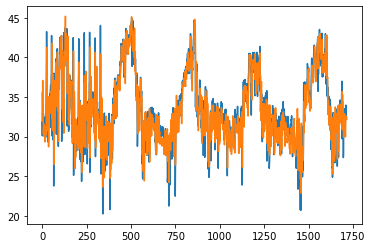

In [15]:
data_unique_district_temp = get_data('Adilabad','temp_max')
data_unique_district_date = get_data('Adilabad','date')
    
  
X,y = convertUnivariateData(data_unique_district_date, data_unique_district_temp,n_steps,n_features)
mse = evalLSTM(model,X,y,10,1)
plt.plot(y)
plt.plot(mse['y_predict'])
plt.show()

In [17]:
model.save('lstm-initial')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: lstm-initial\assets


>## Load the saved model from below

In [4]:
model = load_model('lstm-initial')